In [1]:
%pylab inline
import matplotlib.pylab as plt
import math
import random
import numpy as np
import pandas as pd
from sklearn.cross_validation import train_test_split

Populating the interactive namespace from numpy and matplotlib


## Линейная классификация

Ранее мы изучили задачу восстановления регрессии и способы её решения. В частности, для линейной модели с функционалом качества MSE решение данной задачи выписывается аналитически через матрицу "объект-признак" и вектор ответов обучающей выборки.

Давайте приступим к рассмотрению задачи классификации. Начнём с того, что вспомним её постановку.

### Постановка задачи классификации

Пусть задана обучающая выборка $X = \{ \left( x_i, y_i \right) \}_{i=1}^l, x_i \in \mathbb{X}, y_i \in \mathbb{Y},$ — $l$ пар объект-ответ, где
$\mathbb{X}$ — пространство объектов,
$\mathbb{Y}$ — пространство ответов.

Задача классификации отличается о задачи восстановления регрессии тем, что в данном случае пространство ответов конечно:
$$\left| \mathbb{Y} \right| < \infty.$$


**Примеры**:

1) Кредитный скоринг.
* Объект — заявка на кредит от клиента банка.
* Ответ — решение о выдаче или невыдаче кредита.

2) Медицинская диагностика.
* Объект — характеристики пациента (результаты анализов, общая информация о пациенте, история болезни).
* Ответ — диагноз (одно из ограниченного множества заболеваний).

В дальнейшем будем рассматривать задачу бинарной классификации (то есть разделения объектов на 2 группы) и полагать $\mathbb{Y} = \{-1, +1\}.$

### Линейная модель

Сегодня мы будем рассматривать линейную модель. В случае классификации формула для ответа на объекте $x$ видоизменяется по сравнению с линейной регрессией (при этом мы предполагаем, что нулевой признак в выборке — константный):
$$a(x) = sgn(w_0 \cdot 1 + w_1 x^1 + \dots w_d x^d) = sgn(\sum_{j = 0}^d w_j x^j) = sgn(\langle w, x \rangle).$$

Множество точек $\langle w, x\rangle = 0$ является гиперплоскостью и делит пространство на 2 части по разные стороны от этой самой гиперплоскости. При этом объекты, расположенные по разные стороны от неё, полученный классификатор относит к различным классам в зависимости от знака скалярного произведения.

<tr>
<td> <img src="images/plane.png" alt="Drawing" style="width: 350px;"/> </td>
<td> <img src="images/cube.png" alt="Drawing" style="width: 350px;"/> </td>
</tr>

Отметим, что для некоторого объекта $x$ расстояние до гиперплоскости для фиксированного вектора весов $w$ можно записать как $\frac{\left| \langle w, x \rangle \right|}{\|w \|}$.

Поэтому чем больше $\left| \langle w, x \rangle \right|$, тем дальше объект отстоит от гиперплоскости, тем увереннее алгоритм в его классификации.

### Оптимизируемый функционал

Как и в случае линейной регрессии, поиск оптимального алгоритма среди множества всех линейных моделей в случае классификации производится путем оптимизации некоторого функционала. Можно было бы рассматривать MAE или MSE, как и в случае регрессии, однако в случае классификации этот подход кажется немного странным, как минимум, потому что классы могут задаваться своими названиями, а не номерами. Их можно было бы занумеровать, но тогда результат будет сильно зависеть от способа нумерации.

Будем минимизировать долю неверных классификаций, которую можно записать в следующем виде:

$$Q(w, X) = \frac{1}{l} \sum_{i = 1}^l [a(x_i) \ne y_i] \to \min_w.$$

В этом функционале слагаемое $[a(x_i) \ne y_i]$ отвечает за то, была ли допущена алгоритмом $a(\cdot)$ ошибка на объекте $x_i$.

Заметим, что $[a(x_i) \ne y_i] = [sgn \, \langle w, x_i \rangle \ne sgn \, y_i] = [y_i \langle w, x_i \rangle < 0],$ поэтому функционал можно переписать в следующем виде:
$$Q(w, X) = \frac{1}{l} \sum_{i = 1}^l [y_i \langle w, x_i \rangle  < 0] \to \min_w.$$

Величина $M_i = y_i \langle w, x_i \rangle$ называется **отступом** объекта $x_i$. Как было показано ранее:
* объект верно классифицируется тогда и только тогда, когда отступ положительный;
* чем больше значение отступа, тем надёжнее классифицируется объект.

Тем не менее, получившийся функционал не получится оптимизировать градиентными методами. Поэтому рассмотрим пороговую функцию потерь для одного объекта $\mathscr{L}(M) = [M < 0],$ участвующую в формуле функционала, оценим её сверху некоторой гладкой функцией потерь и будем минимизировать её:

$$Q(w, X) = \frac{1}{l} \sum_{i = 1}^l [M_i < 0] = \frac{1}{l} \sum_{i = 1}^l \mathscr{L}(M_i) \le \frac{1}{l} \sum_{i = 1}^l \widetilde{\mathscr{L}}(M_i) = \widetilde{Q}(w, X) \to \min_{w}$$

Примеры оценок сверху для одного объекта:
<img src="images/est.png" alt="Drawing" style="width: 650px;">

**ВАЖНО**: мы минимизируем верхнюю оценку и надеемся, что тогда будет минимизироваться и исходный функционал $Q(w, X)$, однако нет никаких гарантий, что так и будет!

В зависимости от выбранной верхней оценки будут меняться свойства итогового алгоритма, положение разделяющей гиперплоскости и т.п.

### Итог

Таким образом, процесс обучения линейного классификатора складывается из следующих шагов:

* Получение обучающей выборки $X^l = \{ \left( x_i, y_i \right) \}_{i=1}^l$
* Выбор верхней оценки для пороговой функции потерь — отсюда получаем общий вид оптимизируемого функционала $\widetilde{Q}(w, X^l)$
* Проводим оптимизацию при помощи некоторого метода оптимизации и получаем оптимальное значение $w^*$
* Предсказываем ответы для новых объектов по формуле $a(x) = \langle w^*, x\rangle$

### Логистическая регрессия

Рассмотрим в качестве верхней оценки пороговой функции потерь логистическую функцию:

$$\widetilde{\mathscr{L}}(M) = \log_2(1 + \exp(-M)).$$

Таким образом, необходимо решить следующую оптимизационную задачу:
$$\frac{1}{l} \sum_{i=1}^l \widetilde{\mathscr{L}} (M_i) = \frac{1}{l} \sum_{i=1}^l \log_2 (1 + \exp (-y_i \langle w, x_i \rangle)) \to \min_w$$

Получившийся метод обучения называется **логистической регрессией**.

Давайте получим его, подойдя немного с другой стороны. Допустим, мы решаем задачу бинарной классификации, но хотим получать не только одну из двух меток, но и вероятность принадлежности объекта классу. 

**Пример**: Вы работаете в банке и хотите выдавать кредиты только тем клиентам, которые вернут его с вероятностью не меньше 0.9.

Отметим, что
$$P(y = -1|x) = 1 - P(y = +1|x),$$

поэтому будем работать с вероятностью принадлежности объекта $x$ классу +1, т.е. $P(y = +1|x).$

Мы могли бы считать $\langle w, x \rangle$ вероятностью принадлежности объекта $x$ классу +1, однако, как мы знаем, вероятность обязана лежать в отрезке [0; 1] (что неверно для скалярного произведения). Давайте обернем скалярное произведение в какую-нибудь функцию, которая будет принимать значения в отрезке [0; 1]! Например, **сигмоидную функцию**:

$$\sigma(z) = \frac{1}{1 + \exp(-z)}$$

![Сигмоидная функция](./images/Logistic-curve.svg.png)

Будем считать, что

$$P(y = +1|x) = \sigma(\langle w, x \rangle) = \frac{1}{1 + exp(- \langle w, x \rangle)}$$

На лекции было показано, что при такой постановке логично решать следующую оптимизационную задачу:


$$\frac{1}{l} \sum_{i=1}^l \{ [y_i = +1] \log_2 \sigma(\langle w, x_i \rangle) + [y_i = -1] \log_2 (1 - \sigma(\langle w, x_i \rangle)) \} \to \max_{w}$$

На самом деле, оказывается, что эта задача аналогична уже рассмотренной с использованием логистической функции в качестве аппроксимации. При этом функционал гладкий, и его можно оптимизировать при помощи градиентного спуска!

### Пример обучения логрегрессии
#### Определение спама по тексту электронного письма

Попробуем при помощи моделей линейной классификации построить алгоритм, отделяющий спам от нормальной почты. Для экспериментов воспользуемся небольшим набором данных с [UCI](https://archive.ics.uci.edu/ml/datasets.html). Объекты в датасете соответствуют письмам, которые описаны признаками на основе текста письма, спам — положительный пример для классификации, хорошее письмо — отрицательный пример.

![Spam](./images/spam.jpg)

In [177]:
import pandas
import urllib2

SPAMBASE_NAMES_URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.names'
SPAMBASE_DATA_URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data'

feature_names = [
    line.strip().split(':')[0] 
    for line in urllib2.urlopen(SPAMBASE_NAMES_URL).readlines()[33:]
]
spam_data = pandas.read_csv(SPAMBASE_DATA_URL, header=None, names=(feature_names + ['spam']))
 
X, y = spam_data.ix[:, :-1].values, spam_data.ix[:, -1].values
 
spam_data.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,spam
0,0.00,0.64,0.64,0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0,0.135,0.000,0.000,3.537,40,191,1


In [4]:
import pandas

SPAMBASE_NAMES_URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.names'
SPAMBASE_DATA_URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data'

spam_data = pandas.read_csv(SPAMBASE_DATA_URL, header=None)
 
X, y = spam_data.values[:, :-1], spam_data.values[:, -1]
 
spam_data.head()

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,57
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


### Обучим логрегрессию

In [5]:
from sklearn.linear_model import LogisticRegression

train_part = 0.8
n_train = int(train_part*X.shape[0])
X_tr = X[:n_train]
X_test = X[n_train:]
y_tr = y[:n_train]
y_test = y[n_train:]

lr = LogisticRegression()
lr = lr.fit(X_tr, y_tr)

### Посчитаем качество

In [7]:
from sklearn import metrics

preds = lr.predict(X_test)

print('ACC:', metrics.accuracy_score(y_test, preds))

ACC: 0.813246471227


### SGDClassifier
Объект SGDClissifier позволяет обучать линейные модели классификации и регрессии с помощью стохастического градиентного спуска (т.е. грандиент функции потерь каждый раз вычисляется по одному случайному объекту, и делается шаг).

Полезные параметры:
* loss - функция потерь (по факту то, какую модель обучаем): **hinge** (SVM), **log** (логистическая регрессия), **perceptron** (персептрон) и другие.
* penalty - тип регуляризации: **l1**, **l2**, **elasticnet** (смесь l1 и l2 регуляризации).
* alpha - коэффициент регуляризации.
* fit_intercept - добавлять ли свободный член (true/false).
* n_iter - число эпох (полных проходов по данным) при обучении.
* learning_rate - шаг градиентного спуска (оптимизируется по умолчанию).

In [9]:
from sklearn.linear_model import SGDClassifier
lr_sgd = SGDClassifier(loss="log", alpha=0.05, n_iter=200, fit_intercept=True)
lr_sgd.fit(X_tr, y_tr)
preds_sgd = lr_sgd.predict(X_test)
print('ACC:', metrics.accuracy_score(y_test, preds_sgd))

ACC: 0.85233441911


## Оценка качества работы классификатора
### Бинарные метрики
Обучение и оценка качества модели производится на независимых множествах примеров. Как правило, имеющующиеся примеры разбивают на два подмножества: обучение (`train`) и контроль (`test`). Выбор пропорции разбиения — компромисс: большой размер обучения ведет к более богатым информацией и качественным алгоритмам, большой размер контрольной выборки ведет к менее шумной оценке качества.

Для оценки качества классификации рассматривают [матрицу ошибок](http://en.wikipedia.org/wiki/Confusion_matrix): строчки соответствуют истинному классу, столбцы — предсказанному классификатором, ячейки содержат число примеров тестовой выборки.
![Матрица ошибок](./images/confusion_matrix.png)
Диагональ матрицы ошибок содержит правильно классифицированные положительные (TP) и отрицательные (TN) примеры. False Positive (FP) — ошибки I рода (ложное срабатывание, положили в спам хорошее письмо), False Negative (FN) — ошибки II рода (не отфильтровали спам). Ошибки I и II рода могут иметь различную стоимость.

Часто рассматриваются следующие метрики качества бинарной классификации:
  - Accuracy = (TP + TN) / (TP + TN + FP + FN)  — _доля правильных ответов_
  - Precision = TP / (TP + FP)  — _точность, доля спама среди писем, классифицированных как спам_
  - Recall = TP / (TP + FN)  — _полнота, доля спама, которая была отфильтрована_
  - F1 = 2TP / (2TP + FP + FN)  — _среднее гармоническое между точностью и полнотой_
  
Подробнее про метрики качества бинарной классификации на Википедии: [Precision and Recall](http://en.wikipedia.org/wiki/Precision_and_recall).

### Выбор порога классификации
Многие модели классификации получают оценку принадлежности положительному классу $\tilde{y}(x) \in R$. Затем принимают решение о классе объекта путем сравнения оценки с порогом:

$y(x) = +1$,  если $\tilde{y}(x) \geq \theta$, $y(x) = -1$, если $\tilde{y}(x) < \theta$

Матрица ошибок и все производные от нее метрики (Accuracy, Precision, Recall, etc.) зависят от порога $\theta$:
![Порог классификации](./images/binary_threshold.png) 

Для того чтобы видеть изменения метрик при всех значениях порога классификации, рассматривают координатную плоскость, по осям которой отложены значения метрик, а качество работы классификатора представлено в виде кривой — траектории изменения соответствующих метрик при варьировании порога:
![Принцип построения ROC-кривой](./images/roc_trajectory.png)

Наиболее распространены ROC-кривые (плоскость TP-vs-FP) и Precision/Recall кривые. Аббревиатура ROC ([Receiver Operating Characteristic](en.wikipedia.org/wiki/Receiver_operating_characteristic)) была унаследована из инженерного дела.
![Примеры ROC-кривых](./images/roc_and_pr_curves.png)

В случае, если необходимо сравнить качество классификаторов вне зависимости от порога, применяют интегральные числовые метрики, например AUC-ROC (**A**rea **U**nder RO**C**) — площадь под ROC-кривой классификатора. AUC-ROC идеально работающего классификатора равно 1. Идеальный случайный классификатор в среднем имеет AUC-ROC=0.5.


## Валидация
Чтобы понять насколько хорош наш алгоритм, нам надо провести валидацию. Это один из самых важных шагов в процессе решения задачи. Посмотрим что мы сделали в предыдущей задаче со спамом. 

In [12]:
spam_data = pandas.read_csv(SPAMBASE_DATA_URL, header=None)
 
X, y = spam_data.values[:, :-1], spam_data.values[:, -1]

# обучающая выборка
X_tr = X[:n_train]
y_tr = y[:n_train]

# валидационная выборка
X_test = X[n_train:]
y_test = y[n_train:]

# обучим ещё раз логистическую регрессию
lr = LogisticRegression()
lr = lr.fit(X_tr, y_tr)

#посмотрим на точность классификации

preds = lr.predict(X_test)
print('ACC:', metrics.accuracy_score(y_test, preds))

ACC: 0.813246471227


#### А теперь попробуем перемешать данные и сравним точность:

In [13]:
from sklearn import cross_validation
X_tr, X_test, y_tr, y_test = cross_validation.train_test_split(X, y, test_size=train_part, random_state=123)

# обучим ещё раз логистическую регрессию
lr = LogisticRegression()
lr = lr.fit(X_tr, y_tr)

#посмотрим на точность классификации

preds = lr.predict(X_test)
print('ACC:', metrics.accuracy_score(y_test, preds))

ACC: 0.914425427873


### В чем проблема?

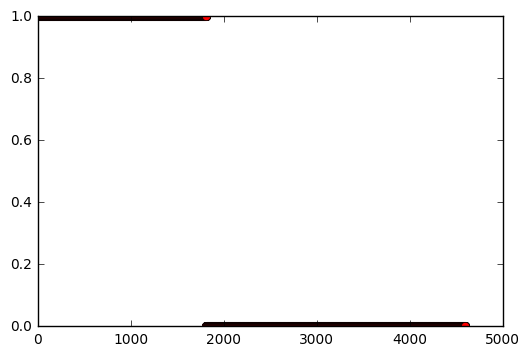

In [14]:
plt.plot(y, 'ro')

Как мы видим, проблема заключалась в том, что в выборке примеры были упорядочены: сначала шли примеры положительного класса, а потом отрицательного! Поэтому нельзя забывать **перемешивать классы**.

Чтобы уменьшить дисперсию, можно разбивать не один раз, а несколько, для этого есть функция [`sklearn.cross_validation.ShuffleSplit`](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.ShuffleSplit.html#sklearn.cross_validation.ShuffleSplit)

In [15]:
cv = cross_validation.ShuffleSplit(n=X.shape[0], n_iter = 5, train_size=0.9, test_size=0.1, random_state=123)
quals = []
lr = LogisticRegression()
for tr_ind, test_ind in cv:
    lr.fit(X[tr_ind, :], y[tr_ind])
    quals.append(metrics.roc_auc_score(y[test_ind], lr.predict_proba(X[test_ind,:])[:,1]))

In [17]:
print('Mean: ', np.mean(quals))
print('std: ', np.std(quals))

Mean:  0.972646980708
std:  0.00736257830467


In [149]:
cv = cross_validation.ShuffleSplit(n=X.shape[0], n_iter = 10, train_size=0.9, test_size=0.1, random_state=124)
quals = []
lr = LogisticRegression()
for tr_ind, test_ind in cv:
    lr.fit(X[tr_ind, :], y[tr_ind])
    quals.append(metrics.roc_auc_score(y[test_ind], lr.predict_proba(X[test_ind,:])[:,1]))

In [150]:
print 'Mean: ', np.mean(quals)
print 'std: ', np.std(quals)

Mean:  0.972364553141
std:  0.00375479842421


In [20]:
means = []
stds = []
xs = []
quals = []
for tr_size in np.arange(0.5,0.9,0.01):
    cv = cross_validation.ShuffleSplit(n=X.shape[0], n_iter = 5, train_size=tr_size, random_state=123)
    fold_quals = []
    lr = LogisticRegression()
    for tr_ind, test_ind in cv:
        lr.fit(X[tr_ind, :], y[tr_ind])
        qual = metrics.roc_auc_score(y[test_ind], lr.predict_proba(X[test_ind,:])[:,1])
        fold_quals.append(qual)
        quals.append(qual)
        xs.append(tr_size)
    means.append(np.mean(fold_quals))
    stds.append(np.std(fold_quals))

Посмотрим как ведут себя качество модели и дисперсия качества в зависимости от размера обучающей выборки

In [209]:
figsize(6,4)

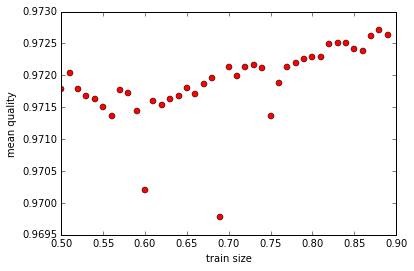

In [213]:
plt.plot(np.arange(0.5,0.9,0.01), means, 'ro')
plt.xlabel('train size')
plt.ylabel('mean quality')

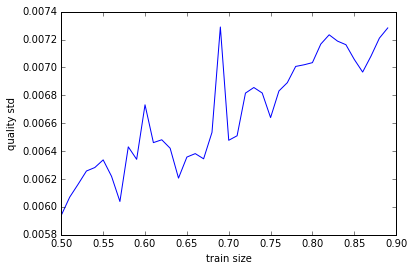

In [214]:
plt.plot(np.arange(0.5,0.9,0.01), stds)
plt.xlabel('train size')
plt.ylabel('quality std')

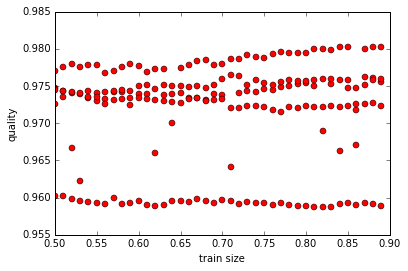

In [212]:
plt.plot(xs, qualss, 'ro')
plt.xlabel('train size')
plt.ylabel('quality')

### Случай с сильно несбалансированными классами
Если объектов одного класса сильно меньше чем других, к тому же выборка небольшая, то есть ненулевая вероятность того, что при случайном разбиении у нас этого класса может почти не оказаться в тестовой выборке, соответственно результаты валидации будут иметь большую дисперсию

- Пример: есть клиенты банка, которые хотят взять кредит, при этом не все из них вернут его

Случаи невозврата кредита очень редки!

In [22]:
df = pd.read_csv('givemesomecredit')
X = df.drop('SeriousDlqin2yrs', axis=1)
X = X.fillna(X.mean()).as_matrix()
y = df['SeriousDlqin2yrs']
print("доля заемщиков не вернувших кредит:", y.mean())

доля заемщиков не вернувших кредит: 0.00712606000143


- Всего 0.7% доля объектов одного класса

- В таком случае надо делать стратификацию, то есть разбивать отдельно объекты каждого класса на обучение и контроль (сохраняя их доли).

**Посмотрим как влияет на оценку качества стратификация**

In [23]:
cv = cross_validation.ShuffleSplit(n=X.shape[0], n_iter = 10, train_size=0.9, test_size=0.1, random_state=124)
quals = []
lr = LogisticRegression()
for tr_ind, test_ind in cv:
    lr.fit(X[tr_ind, :], y[tr_ind])
    quals.append(metrics.roc_auc_score(y[test_ind], lr.predict_proba(X[test_ind,:])[:,1]))

print("mean = ", np.mean(quals))
print("std = ", np.std(quals))

mean =  0.6489656795
std =  0.0755664858797


In [24]:
cv = cross_validation.StratifiedShuffleSplit(y, n_iter = 10, train_size=0.9, test_size=0.1, random_state=124)
quals = []
lr = LogisticRegression()
for tr_ind, test_ind in cv:
    lr.fit(X[tr_ind, :], y[tr_ind])
    quals.append(metrics.roc_auc_score(y[test_ind], lr.predict_proba(X[test_ind,:])[:,1]))

print("mean = ", np.mean(quals))
print("std = ", np.std(quals))

mean =  0.670975609756
std =  0.0680097508336


- Как мы видим, в первый раз мы делали все совсем неправильно.

- Стратификация позволяет уменьшить дисперсию и более точно оценить качество

#### Рассмотрим следующую задачу 
данные по больным бесплодием, выборка - около 100 человек, каждый больной может нести в себе новую важную информацию, поэтому мы хотим сделать обучающую выборку как можно больше, при этом можем позволить себе обучать классификатор много раз.

Для этого используем [`LeaveOneOut`](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.LeaveOneOut.html#sklearn.cross_validation.LeaveOneOut).

Мы по одному объекты выкидываем из обучающей выблорки, обучаем модель и предсказываем на этом объекте.

In [25]:
df = pd.read_csv('fertility', sep = ',', header = None)
X = df.ix[:,:8]
y = np.zeros(df.shape[0])
y[df[9].as_matrix() == 'N'] = 1

cv_LOO = cross_validation.LeaveOneOut(n = len(y))
qual = []
for tr_ids, test_ids in cv_LOO:
    lr.fit(X.ix[tr_ids,:], y[tr_ids])
    qual.append(lr.predict(X.ix[test_ids, :]) == y[test_ids])
print("ACC =", np.mean(qual))


ACC = 0.88


Если же объектов много, то очень затртано обучать модель для проверки каждого объекта.

Но мы хотим чтобы все-таки **каждый объект побывал и в train и в test**, причем одинаковое количество раз.

Для этого можно сделать следующим образом: разбить случайным образом всю выборку на K блоков, и каждый из блоков по одному разу сделать тест сетом.

Этот метод называется K-Fold. В sklearn он представлен [`sklearn.cross_validation.KFold`](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.KFold.html#sklearn.cross_validation.KFold)

In [26]:
cv = cross_validation.KFold(n=len(y), n_folds=5, random_state=123, shuffle=True)
lr = LogisticRegression()
quals = []
for tr_ids, test_ids in cv:
    lr.fit(X.ix[tr_ids,:], y[tr_ids])
    quals.append(metrics.accuracy_score(y[test_ids], lr.predict(X.ix[test_ids, :])))

print("accuracy:", np.mean(quals), np.std(quals))

accuracy: 0.88 0.0509901951359


### Вопросы:
1. Как соотносятся KFold и LOO кроссвалидации|?
2. Что общего у KFold и ShuffleSplit?

### Настройка параметров модели
Настройка наилучших параметров модели производится с и пользовнием техник кросс-валидации (для оценки качества) и соответственно перебора параметров. 

Для перебора параметров можно использовать: 
- Модуль для перебора параметров модели по сетке [`sklearn.grid_search`](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.grid_search)
  - Класс [`GridSearchCV`](http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.GridSearchCV.html#sklearn.grid_search.GridSearchCV) — полный перебор параметров модели по сетке
  - Класс [`RandomizedSearchCV`](http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.RandomizedSearchCV.html#sklearn.grid_search.RandomizedSearchCV) — перебирает случайные комбинации параметров

## Краткий справочник по SciKit-Learn

Обратите внимание на следующую функциональность библиотеки SciKit-Learn:

- Модуль для оценки качества моделей и кросс валидации [`sklearn.cross_validation`](http://scikit-learn.org/stable/modules/cross_validation.html):
  - функция разбиения выборки [`train_test_split()`](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.train_test_split.html#sklearn.cross_validation.train_test_split)
  - итераторы разбиений для кросс-валидации: [`LeaveOneOut`](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.LeaveOneOut.html#sklearn.cross_validation.LeaveOneOut), [`KFold`](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.KFold.html#sklearn.cross_validation.KFold), [`ShuffleSplit`](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.ShuffleSplit.html#sklearn.cross_validation.ShuffleSplit)
  - всегда указывайте параметр `random_state`, это сделает код вашего эксперимента воспроизводимым: при повторном запуске разбиения будут одинаковыми
- Модуль с метриками качества моделей [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics)
  - [`accuracy_score(y_true, y_pred)`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)
  - [`precision_recall_fscore_support(y_true, y_pred)`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html#sklearn.metrics.precision_recall_fscore_support)
  - [`roc_curve(y_true, y_score)`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve)
  - [`precision_recall_curve(y_true, y_score)`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html)
  - [`roc_auc_score(y_true, y_score)`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score)

- Модуль для перебора параметров модели по сетке [`sklearn.grid_search`](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.grid_search)
  - Класс [`GridSearchCV`](http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.GridSearchCV.html#sklearn.grid_search.GridSearchCV) — полный перебор параметров модели по сетке
  - Класс [`RandomizedSearchCV`](http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.RandomizedSearchCV.html#sklearn.grid_search.RandomizedSearchCV) — перебирает случайные комбинации параметров
  
### Руководства и примеры из документации

- [Оценка качества предсказаний](http://scikit-learn.org/stable/modules/model_evaluation.html)
- [Оптимизация параметров по сетке с использованием кросс-валидации](http://scikit-learn.org/stable/auto_examples/grid_search_digits.html)
- [ROC-кривые](http://scikit-learn.org/stable/auto_examples/plot_roc.html), [Precision-Recall кривые](http://scikit-learn.org/stable/auto_examples/plot_precision_recall.html)